<a href="https://colab.research.google.com/github/JJang-likit/GoingDeeper_Aiffel/blob/main/GoingDeeper13_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoingDeeper13_멀리 있지만 괜찮아_얼굴인식프로젝트



*   Dlib 라이브러리를 사용해서 Face Landmark 검출을 진행하였을 때 몇 가지의 문제점이 발생하였다.
  - 얼굴을 잘 못찾는다.
  - 동영상을 처리하기엔 너무 느리다.
  - 얼굴각도, 방향, 크기 등의 변화에 취약하다.
  - 그 외에도 많은 문제점이 있다.
- 비대면 인증수단으로 얼굴인식이 보편적으로 사용되기 시작하면서 Face detection이 중요해졌다.





*   이러한 Face detection을 빠르게 진행하기 위해서는 몇 가지 고려해야 할 점이 있다.
  - 시간이 많이 드는 Sliding window 기법을 버려야 한다.
  - 2 - stage 방식의 detection은 좋은 선택이 아니다.
  - 연산의 병렬화가 가능해야 한다.
*   컴퓨터에서는 GPU를 통한 병렬화가 가능하지만 핸드폰에서도 가능할까?
  - 안드로이드에서는 MLKit, 아이폰에서는 CoreML이라는 라이브러리를 통해 병렬화를 할 수 있다.
  - MLKit - https://developers.google.com/ml-kit
  - CoreML - https://developer.apple.com/documentation/coreml



## Single Stage Object Detection

- 2-Stage Detector는 정확도는 높지만 실행속도(FPS)가 느리다.
- 물체가 존재하는 bounding box를 먼저 찾은 후에 bounding box를 분류하는 두 가지 과정을 순차적으로 거치기 때문에 속도가 느려진다.
- 그렇기 때문에 얼굴 인식 같은 딥러닝 모델이 가벼워야 하는 task에는 1-Stage 기반을 사용하는 것이 유리하다.
- 1-Stage Detector는 localization과 classification을 동시에 수행한다.
- 하지만 정확도가 낮다는 단점도 존재한다.

## YOLO : You Only Look Once
- YOLO는 2016년 CVPR oral session에서 실시간으로 공개되었다.

- YOLO의 특징은 'You Only Look Once : Unified, Read-Time Object Detection'라는 논문제목에 잘 드러나 있다.
- You Only Look Once
 * 전체 이미지를 보는 횟수가 1회라는 것을 의미한다. YOLO는 클래스에 대한 정보와 주변 정보까지 한번에 학습하고 처리한다. 따라서 배경 오류가 적고 일반화 성능이 좋다.
- Unified
  * Localization과 Classification을 동시에 수행한다. 따라서 YOLO는 이미지를 신경망에 넣어주기만 하면 바로 detection이 가능하다.
- Real-Time
  * 기본적인 YOLO 모델은 45FPS(초당 프레임수), 빠른 버전은 150FPS까지 성능을 보인다. 따라서 스트리밍 비디오에서도 실시간으로 객체를 detection 할 수 있다.
  * 그 외에도 Object detection을 회귀 문제로 관점을 전환하였고 여러 도메인에서 object detection이 가능하다는 특징을 가지고 있다.


## RCNN과 YOLO
- 대표적인 2-Stage detector인 RCNN과 1-Stage detector인 YOLO는 몇 가지 차이가 있다.
  * RCNN 계열의 가정 : 객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다 - Region Proposal Network(RPN)
  * YOLO v1의 가정 : 이미지 내의 작은 영역을 나누면 그 곳에 객체가 있을 수 있다. - grid 내에 객체가 존재한다.
- 따라서 YOLO v1에는 grid는 고정되고 각 grid 안에 객체가 있을 확률이 중요하게 된다.

### YOLO의 Grid cell
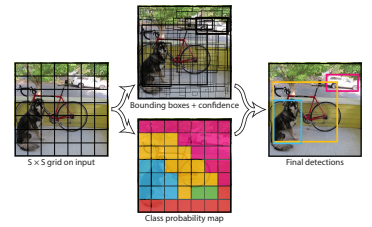



1. YOLO는 이미지를 S x S grid로 나누고 box regression 단계와 각 클래스마다 probability map을 구하는 단계가 동시에 병렬적으로 수행된다.
2. 각 grid cell은 bounding box(bbox)와 C개의 class확률을 예측한다.
3. 각 bounding box는 x, y, w, h, confidence score를 예측한다. x, y는 bbox의 중심 좌표이고 x, h는 너비와 높이를 의미한다. 주의할 점은 w, h는 입력이미지를 bbox의 너비와 높이를 나눠서 normalize한 값으로 0과 1 사이의 값을 가진다.
4. confidence score는 box가 객체를 포함하고 있는지를 모델이 얼마자 자신 있는지, 그리고 박스가 예측하는 것이 얼마나 정확한지를 보여준다.
5. 만약 gird cell이 객체를 포함하지 않으면 P(Object)의 값이 0이므로 confidence score는 0이 된다. 그리고 객체를 포함하고 있는 경우에는 값이 1이 된다. 

### NMS(Non-Maximum Suppression)
- 위의 이미지를 보면 자전거를 포함하는 grid가 많은 것을 확인할 수 있다.
- 학습이 잘 된 경우 해당 grid들이 모두 비슷한 크기로 자전거의 bbox를 잡는다.
- 여기서 동일한 객체를 잡는 bbox가 많아진다는 문제가 생긴다.
- 이런 문제를 해결하기 위해 비-최대 억제라고 불리는 NMS기법을 사용해서 object detector가 예측한 여러 개의 bounding box 중 정확한 bounding box만을 선택하도록 한다.
- NMS의 알고리즘은 다음과 같다.
  * 하나의 클래스에 대한 높은 confidence score 순서대로 bbox를 정렬한다. confidence score가 특정 threshold를 넘지 않는 것은 제거한다.
  * 가장 높은 Confidence Score의 bbox와 겹치는 다른 bbox를 비교하여 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거한다. 두 bbox의 IoU가 높다는 것은 같은 객체를 detect하고 있다는 의미이기 때문이다.
  * 1과 2의 과정을 반복해 마지막으로 남은 bbox를 반환한다.
  * 각 클래스에 대해 위의 과정을 반복한다.

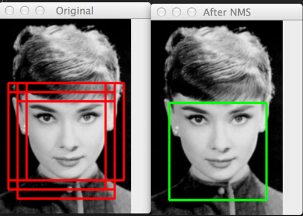

- NMS알고리즘을 적용하면 그림과 같이 겹쳐있는 bounding box 중 정확한 bounding box만 표시된다.

### YOLO의 네트워크 구조

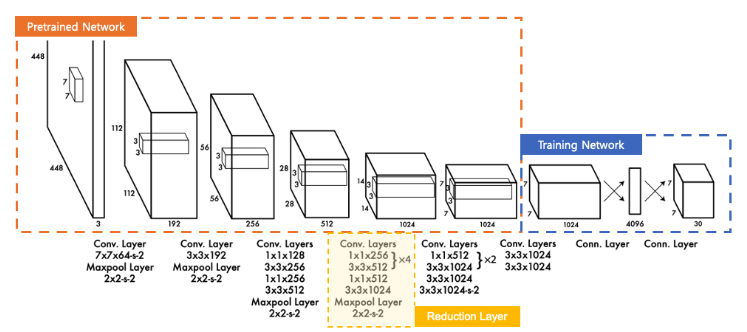

- YOLO의 네트워크 구조는 아래 그림과 같이 24개의 Conv 레이어와 2개의 Fully connected 레이어로 이루어져 있다.
- 모델 구조의 앞부분(Pretrained)는 imageNet의 1000개 클래스 데이터셋을 가지고 사전학습한 GoogLeNet 모델이다.
- 사전학습을 위해 20개의 Conv레이어와 average pooling 레이어와 fully-connected레이어를 사용한다.
- GoogLeNet의 Inception 모듈 대신 1x1 reduction 레이어를 사용하여 연산량을 감소시켰다.
- detection을 위해 사전학습된 모델에 4개의 Conv 레이어와 2개의 FC 레이어를 추가하였고 PASCAL VOC 데이터셋으로 fine-tunning하였다.
- fine-grained 이미지를 얻기 위해 원래의 224x224 이미지의 2배인 448x448의 이미지를 사용하였다.
- 마지막 레이어는 Class 확률과 bbox 좌표를 학습하고 예측하여 S x S x(B * 5 + C) 크기의 텐서로 예측값이 출력된다.

### YOLO의 Inference 과정

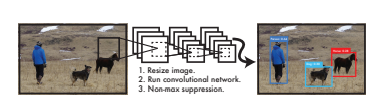

- Inference를 할 때는 조건부 클래스 확률 P(Class_i|Object) 를 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score(class-specific confidence score)를 얻을 수 있습니다. 각 score는 box의 클래스의 확률과 예측된 box가 사물을 얼마나 잘 예측하는지를 보여줍니다.
- 이 과정을 모든 bbox에서 시행하면 한 이미지에서 예측한 클래스별 confidence score의 개수는 7 * 7 * 2 = 98개입니다. 이 98개의 클래스별 confidence score에 대해 20개의 class를 기준으로 NMS를 하여 object에 대한 class와 bounding box location을 결정할 수 있습니다.

### YOLO의 loss 함수
- YOLO의 loss는 bbox의 위치 예측과 관련된 localization loss와 클래스 예측과 관련된 classification loss가 있으며 두 loss 모두 SSE(sum-squared error)를 기반으로 한다.
- SSE는 두 loss 모두 동일하게 가중치를 준다. 이런 경우는 confidence score가 0에 가깝게 되면서 모델의 불균형을 초래한다.
- 이런 문제를 해결하기 위해서 bbox의 좌표에 대한 loss를 증가시키고 객체가 없는 box의 confidence 예측값의 loss는 감소시킨다.
- 또한 SSE는 큰 bbox와 작은 bbox의 loss를 모두 동일한 가중치로 계산한다. 그러나 작은 bbox가 큰 bbox보다 조그마한 위치 변화에도 더 민감하기 대문에 bbox의 너비와 높이에 square root를 취해준다.

### YOLO의 성능
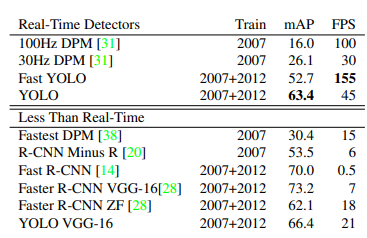

- 초기 YOLO의 성능은 mAP가 63.4였지만 CVPR 2016 발표당시에는 69.0으로 모델 성능이 향상되었다.
- YOLO v1은 Faster-R-CNN과 성능에 큰 차이가 나지는 않지만 속도는 6배 이상 차이가 난다.

### YOLO v1의 단점
- 각각 grid cell이 2개의 box와 하나의 클래스만 예측 가능하므로 가까이에 있는 여러개의 객체를 예측하기가 어렵다. 특히 새떼와 같이 그룹으로 나타나는 작은 object에 대해 예측을 잘 못한다.
- bbox의 형태가 training data를 통해 학습되었기 때문에 bbox 분산이 너무 넓어 새로운 형태의 bbox 예측이 잘 안되는 경우가 있다. 모델 구조상 backbone만 거친 feature map을 대상으로 bbox 정보를 예측하기 때문에 localization이 다소 부정확하다.
- loss함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기 때문에 큰 box의 작은 loss보다 작은 box의 작은 loss가 IoU에 더 큰 영향을 미친다.

## YOLO v2
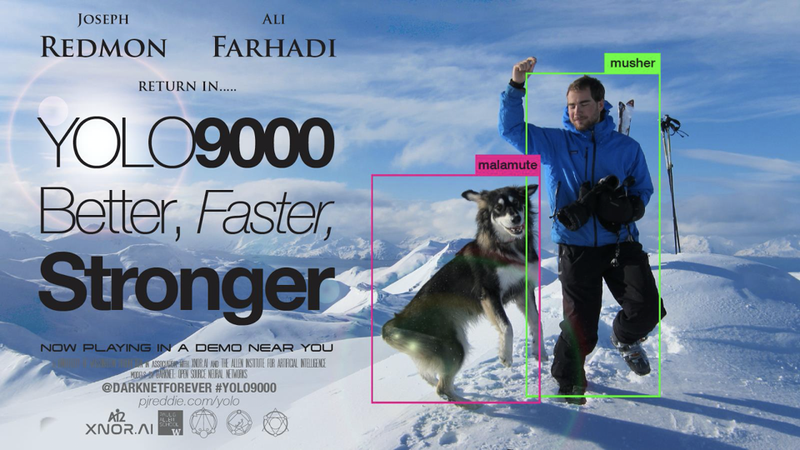
- YOLO v2는 2017년 YOLO v1을 발전시켜서 새롭게 발표된다.
- YOLO v2는 다음과 같은 목적을 가지고 개발되었다.
  * Make it better
  * Do it faster
  * Makes us stronger
- 간단하게 요약하면 recall을 올리고 localization을 잘 해보자는 의미이다.





### Make it better
- Better은 정확도를 올리기 위한 방법이다.
- YOLO v2에서는 이전 모델에서 낮은 성능으로 보였던 localization과 recall을 높이면서 여전히 모델을 단순하고 빠르게 만드려고 하였다.
- 이를 위해 Batch Normalization, High Resolution Classifier, Convolutional with Anchor boxes, Dimension Clusters, Direct location prediction, Fine-Grained Features, Multi-Scale Training 등의 방법을 사용하였습니다.

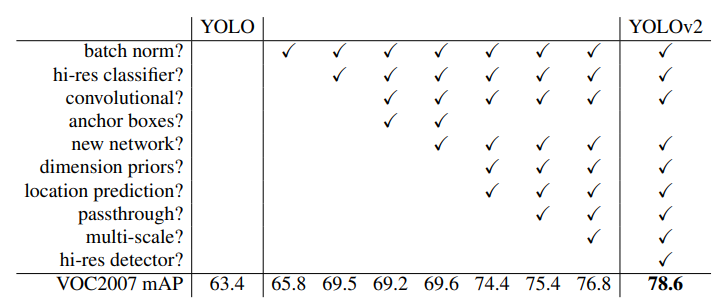

- Batch Normalizaion 
  * 모든 conv 레이어에 batch normalizaion을 사용하였고 dropout은 제거하였다. 이를 통해서 mAP에서 2% 이상의 성능 개선을 보았다.
- High Resolution Classifier
  * YOLO v1에서는 ImageNet의 224x224 이미지를 학습하고 detection에서 448x448 이미지를 사용하였다면 v2모델에서는 처음부터 448x448의 해상도로 학습하였다. 이를 통해서는 mAP에서 약 4%의 성능 개선을 이루었다.
- Convolutional With Anchor Boxes
 * bounding box를 예측하기 위해 v1모델의 Fully connected 레이어를 제거한 후 Fully Convolutional Network를 사용하였고 anchor box들을 사용해 bounding box를 예측하였다. 이를 통해서 mAP는 69.5에서 69.2로 떨어졌지만 recall은 81%에서 88%로 증가하였다.
- Dimension Cluster
 * v2 모델은 k-means clustering을 적용해 최적의 anchor box를 결정한다. 클러스터링 개수를 늘리면 정확도가 높아지지만 속도가 느려지므로 v2는 최종적으로 5개의 anchor box를 사용한다.
- Multi-Scale Training
 * 모델이 다양한 입력 사이즈에도 예측을 잘 할 수 있도록 매 10개의 batch마다 입력 이미지의 크기를 바꿔가면서 모델 학습을 진행한다. 모델이 32 간격으로 downsample 되므로 입력 이미지는 32의 배수가 될 수 있다.

### DO it faster
- faster는 detection 속도를 향상시키기 위한 방법이다.
- v2 모델에서는 Fully Connected 레이어를 제거하고 global average pooling을 하여 가중치 파라미터 수를 크게 줄였다.
- 이렇게 해서 만든 최종 모델은 Darknet-19라고 불린다.
- Darknet-19는 19개의 convolutional 레이어와 5개의 maxpooling 레이어로 이루어져 있다.
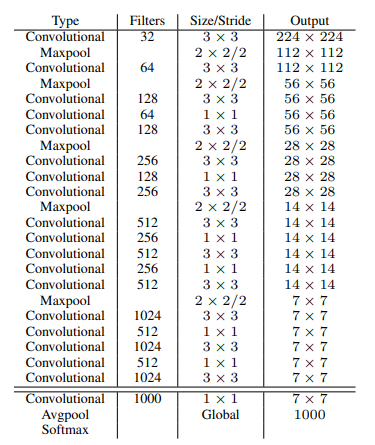

### Makes us stronger
- stronger는 더 많은 범위의 class를 예측하기 위한 방법이다.
- v2 모델에서는 9천개의 클래스에서 detection 할 수 있도록 하고 그 모델을 YOLO9000이라고 불렀다.
- 9천개의 클래스에 대해 분류를 하기 위해 계층적으로 분류 작업을 수행하여 기존의 WorkNet 기반의 데이터를 트리 구조인 WordTree를 생성한다.

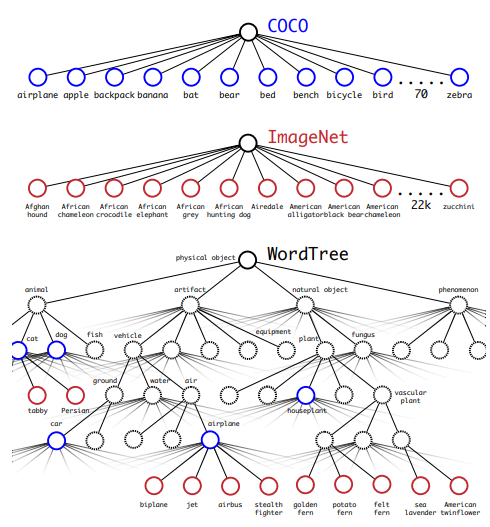

- ImageNet + COCO 데이터셋 + ImageNet Detection을 합쳐 9천개의 클래스 라벨을 생성한다.
- 그 후 Detection과 Classification을 합쳐서 학습을 한다.
- 여기서 Detection 데이터셋과 Classification 데이터셋의 개수가 차이가 크기 때문에 oversampling 하여 Detection 과 Classification 비율을 4:1로 맞춰준다.
- Detection 데이터셋은 classification과 bbox에 대한 loss를 역전파하였지만 Classification 데이터셋은 classification loss만 역전파하여 학습한다.

### YOLO v2의 성능비교

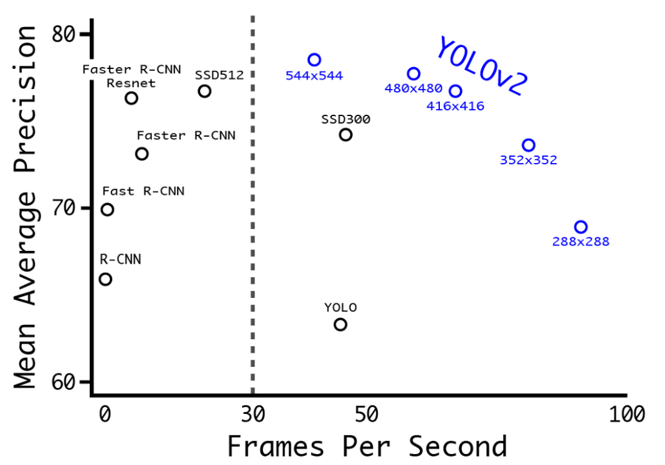

- YOLO v2의 성능은 그래프에서 볼 수 있듯이 mAP가 상승하고 FPS도 개선된 것을 확인할 수 있다.
- YOLO v2 발표 당시 SSD, R-FCN 등이 발표된 상황이었고 특히 SSD의 경우 YOLO와 같이 single stage 방법을 사용하기 때문에 경쟁 모델이 되었다.

## YOLO v3
- YOLO v3은 v2보다 속도는 조금 느리지만 정확도를 개선해서 특히 작은 물체를 detection 할 때 성능이 향상되었다.
- v2 모델에서 약간의 변화가 추가되었다. 

### Bounding Box Prediction
-  v3 모델에서는 각각의 bounding box 마다 objectness score, 즉 bounding box에 물체가 있는지를 예측하는 점수를 logistic regression을 사용해 예측하였다.

### Class Prediction
- v3 모델에서는 하나의 이미지에 다양한 label을 붙일 수 있는 multilabel classification을 하였다.
- 예를 들면 여성 이미지에 person과 woman이라는 두 가지의 label을 붙일 수 있따.
- 이를 위해 여러 개 중 하나만 찾는 softmax classifier가 아닌 해당 label이 맞는지 아닌지를 판단하는 logistic classifier를 사용하였고 binary cross entropy를 사용해 loss를 계산하였다.

### Predictions Across Scales
- v3은 3개의 scale로 bounding box를 예측하였고 각 scale당 3개의 bounding box를 예측한다.

### DarkNet-53
- 성능을 높이기 위해 v3은 53개의 레이어를 사용한다.
- v2의 아키텍처였던 DarkNet-19에 residual network를 넣어 레이어를 53개까지 쌓을 수 있다.
- DarkNet-53은 DarkNet-19보다 정확도가 높고 ResNet-101이나 ResNet152와 성능은 비슷하지만 연산면에서 더 효율적이다.